## Bigram

This notebook contains implementation of one of the simplest NLP models called Bigram with data containing unique polish names.

In [1]:
import os
import csv

### Load and prepare data

In [2]:
files = [file for file in os.listdir(".") if file.endswith(".csv")]

men = []
women = []

with open(files[0], 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=",")
    header = next(file)
    for row in file:
        men.append(row[0].lower())

with open(files[1], 'r') as csvfile:
    file = csv.reader(csvfile, delimiter=',')
    header = next(file)
    for row in file:
        women.append(row[0].lower())
    

In [3]:
print(f"Number of men names according to PESEL register {len(men)}, number of women {len(women)}.")

Number of men names according to PESEL register 32145, number of women 22403.


In [4]:
with open("./polish_names.txt", 'w') as names:
    names.writelines(map(lambda name: f"{name}\n", men))
    names.writelines(map(lambda name: f"{name}\n", women))

In [5]:
names = men + women
len(names)

54548

In [6]:
def isascii(string: str):
    for ch in string:
        if ord(ch) not in range(97, 123): return False
    return True

filtered_names = [name for name in filter(lambda item: isascii(item), names)]
print(f"Number of names without words containing nonascii characters {len(filtered_names)}.")

Number of names without words containing nonascii characters 46168.


In [7]:
characters = list(sorted(set(''.join(filtered_names))))
print(f"Number of unique characters: {len(characters)}")

Number of unique characters: 26


In [8]:
stoi = {ch:i + 1 for i, ch in enumerate(characters)}
stoi['.'] = 0
itos = {i:ch for ch, i in stoi.items()}
print(stoi['a'], stoi['z'])
print(itos[0], itos[25])

1 26
. y


Create special sign for beginning and end of the string sequence

### Creating Bigram model using PyTorch API

For sake of faster computations I'm running PyTorch on my GPU with CUDA cores.

In [9]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [10]:
names = torch.zeros((len(stoi), len(stoi)), dtype=torch.int32, device="cuda")
names.size()

torch.Size([27, 27])

Now we want to create pairs of characters such that we can deduce later on with what probability for example letter 's' comes before 'y' etc.

In [11]:
#Example of what we are looking for
tmp = ['.'] + list(filtered_names[1]) + ['.']
for char1, char2 in zip(tmp, tmp[1:]):
    print(char1, char2)

. k
k r
r z
z y
y s
s z
z t
t o
o f
f .


Thanks to this method we can map every character to row, column position in a matrix and hold frequency of certain letters occuring after the other.

Example:
    map[0][1] = 10

    Means that "b" comes after "a" 10 times in our dataset because 0 = a, 1 = b. stoi and itos map these values

In [12]:
for name in filtered_names:
    tmp = ['.'] + list(name) + ['.']
    for char1, char2 in zip(tmp, tmp[1:]):
        names[stoi[char1], stoi[char2]] += 1

#### Create nice visualization of number of occurences in our dataset

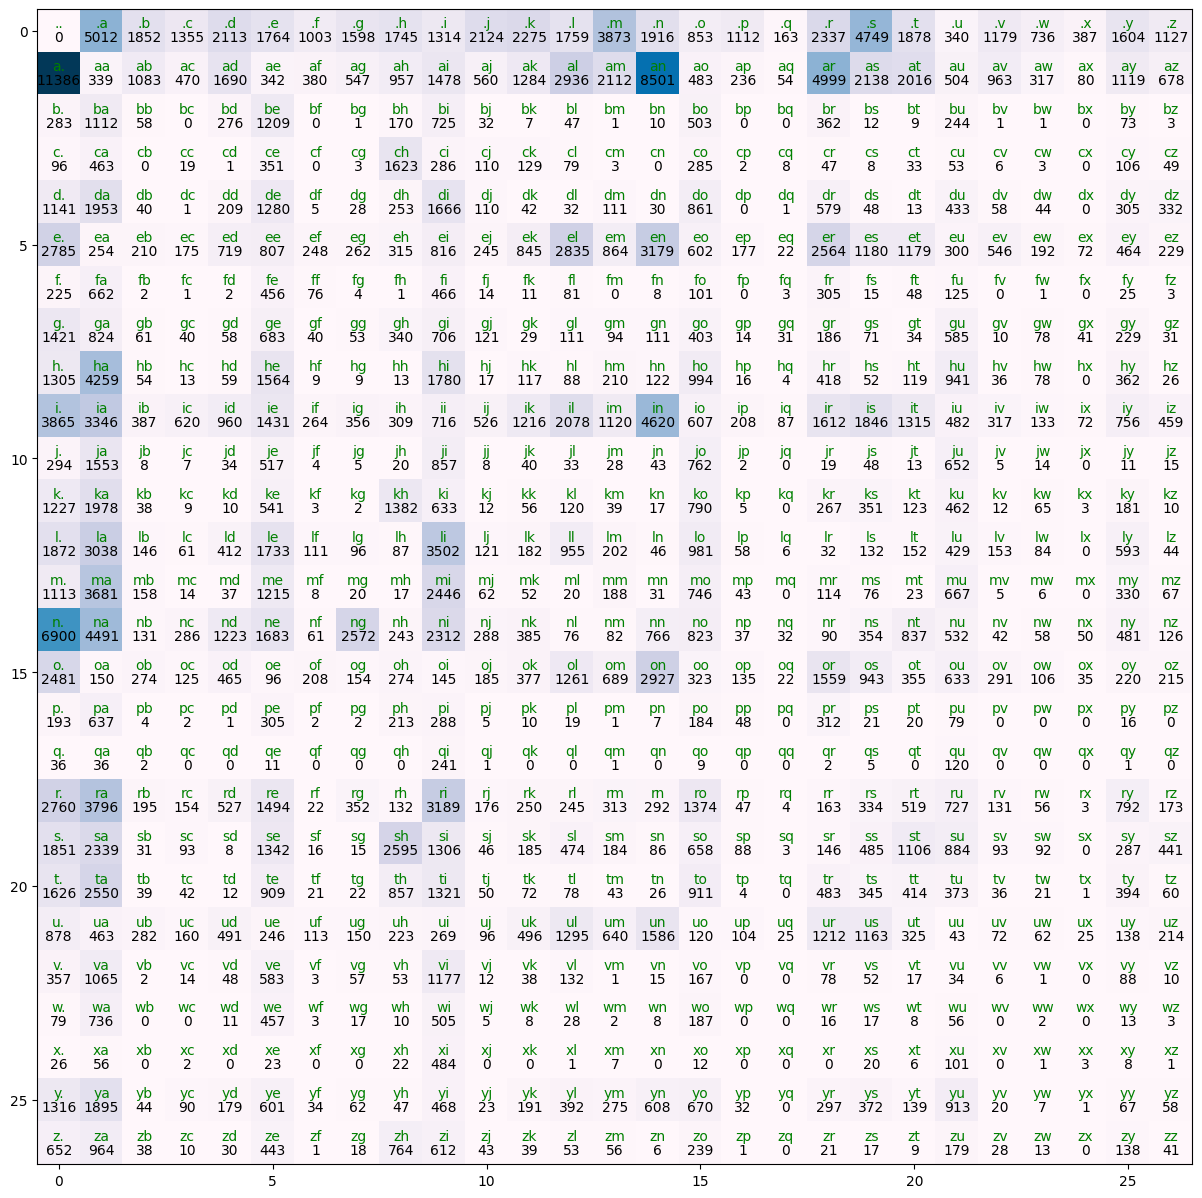

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

#for accessing data from host, copy data from gpu to cpu
cpu_m = names.cpu()

plt.figure(figsize=(15,15))
plt.imshow(cpu_m, cmap='PuBu')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chr = itos[i] + itos[j]
        plt.text(j, i, chr, ha='center', va='bottom', color='green')
        plt.text(j, i, cpu_m[i, j].item(), ha='center', va='top', color='black')

As we can se from the diagram above, in Polish name is most likely to finish with letter 'a'.

### Create Bigram model

In [14]:
names.shape

torch.Size([27, 27])

In [15]:
row_sums = names.float().sum(1, keepdim=True)
row_sums

tensor([[46168.],
        [47652.],
        [ 5139.],
        [ 3763.],
        [ 9575.],
        [22086.],
        [ 2635.],
        [ 6405.],
        [12665.],
        [29708.],
        [ 4992.],
        [ 8336.],
        [15228.],
        [11139.],
        [24961.],
        [14648.],
        [ 2369.],
        [  465.],
        [18220.],
        [14854.],
        [10710.],
        [10891.],
        [ 4010.],
        [ 2171.],
        [  773.],
        [ 8801.],
        [ 4415.]], device='cuda:0')

In [16]:
print(f"Map size: {names.shape}, row sum shape: {row_sums.shape}.")

Map size: torch.Size([27, 27]), row sum shape: torch.Size([27, 1]).


In [17]:
#Divide map / row_sums is broadcastable operation
probabilites = names.float() / row_sums
probabilites[:1]

tensor([[0.0000, 0.1086, 0.0401, 0.0293, 0.0458, 0.0382, 0.0217, 0.0346, 0.0378,
         0.0285, 0.0460, 0.0493, 0.0381, 0.0839, 0.0415, 0.0185, 0.0241, 0.0035,
         0.0506, 0.1029, 0.0407, 0.0074, 0.0255, 0.0159, 0.0084, 0.0347, 0.0244]],
       device='cuda:0')

In [18]:
probabilites.sum(1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')

Probabilites are summing to one so everything is as it should be.

In [19]:
probabilites[1, :]

tensor([0.2389, 0.0071, 0.0227, 0.0099, 0.0355, 0.0072, 0.0080, 0.0115, 0.0201,
        0.0310, 0.0118, 0.0269, 0.0616, 0.0443, 0.1784, 0.0101, 0.0050, 0.0011,
        0.1049, 0.0449, 0.0423, 0.0106, 0.0202, 0.0067, 0.0017, 0.0235, 0.0142],
       device='cuda:0')

Calculate loss

In [20]:
log_likelihood = .0
n = 0

for name in filtered_names:
    tmp = ['.'] + list(name) + ['.']
    for char1, char2 in zip(tmp, tmp[1:]):
        names[stoi[char1], stoi[char2]] += 1
        log_likelihood += probabilites[stoi[char1], stoi[char2]].log()
        n += 1
print(f"Negative log likelihood: {-(log_likelihood/n).item()}")

Negative log likelihood: 2.5771312713623047


In [21]:
for letter in probabilites[0].multinomial(27, replacement=True):
    print(itos[letter.item()], end=', ')

t, m, z, w, g, c, i, h, t, r, m, n, s, k, v, d, h, m, a, g, l, s, b, t, m, k, a, 

In [22]:
def show_results(probabilites):
    for _ in range(10):
        index = 0
        letters = []
        while True:
            #choosing from starting character
            item = torch.multinomial(probabilites[index], 1, replacement=True).item()
            letters.append(itos[item])
            index = item
            if not index:
                break
        print(''.join(letters))

show_results(probabilites)

a.
strekinarion.
firzenatomeodavg.
tzkhynduahom.
vulilon.
otidraele.
josi.
dilliohwaiy.
k.
ak.


As we can see some of the results have certain parts simmilar to real polish names, its still better than non trained model below but bigram is very simple statistics model, there is no correlation between different lettter than the next one.

In [23]:
#Create equally distributed(non-trained) model
non_trained = torch.ones((27,27)) / 27
non_trained

show_results(non_trained)

xdmxwucxtzgxcizcwmdqcflxcyyiusypzx.
lavyiiaogrkaolwxjtaxltvyfjoqnkjcgwmfewbzzqopauizgmuasjsqovvjmzdwxbnkclgxu.
plstvzaxuio.
orffxiakhqogsrdvudpclxovzq.
gf.
omfjdqekpvbhsipplovtnbmjczucsofkhljyesbjsqfsctxlfhgmemffivjnzx.
rnootowpjoyzhdakyjcsrezfttf.
tomrxjptmshhbxijiusuvvbnsenyjouzqyfvjdzd.
ppomeaxohrveuylslzrdazjlt.
hvfhglgwqgvuh.


We can observe that this is complete rubbish in comparision to "trained" model above.

## Different approach using neural network

In [24]:
import torch.nn.functional as F

In [25]:
example = torch.tensor(list(map(lambda char: stoi[char], filtered_names[1])))
print(f"Name: {filtered_names[1]} is transformed into -> {example}, then tensor is one-hot encoded\n->{F.one_hot(example, num_classes=27)}")

Name: krzysztof is transformed into -> tensor([11, 18, 26, 25, 19, 26, 20, 15,  6]), then tensor is one-hot encoded
->tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

### Create training set of inputs and desired outputs.

In [26]:
x_train, y_train = [], []

for word in filtered_names:
    chars = ['.'] + list(word) + ['.']
    for char_x, char_y in zip(chars, chars[1:]):
        x_train.append(stoi[char_x])
        y_train.append(stoi[char_y])
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

print(f"Number of examples in training set: {x_train.nelement()}")

Number of examples in training set: 342779


#### Forward and backward pass

Initialize weights

In [27]:
Weights = torch.randn(names.shape, requires_grad=True)

In [29]:
num_epochs = 100
learning_rate = -50

for i in range(num_epochs):
    #forward pass encode training set into one hot matrix
    encoded = F.one_hot(x_train, num_classes=27).float()

    #calculate activation
    activation = (encoded @ Weights).tanh()

    #calculate probabilites (softmax)
    logits = activation.exp()
    probs = logits / logits.sum(1, keepdims=True)

    #negative log likelihood loss function    
    loss = -probs[torch.arange(x_train.nelement()), y_train].log().mean()
    if (i + 1) % 10 == 0:
        print(loss)
    #Erase previous gradients and perform backward pass
    Weights.grad = None
    loss.backward()

    #update weights
    Weights.data += learning_rate * Weights.grad


tensor(2.7538, grad_fn=<NegBackward0>)
tensor(2.7463, grad_fn=<NegBackward0>)
tensor(2.7424, grad_fn=<NegBackward0>)
tensor(2.7393, grad_fn=<NegBackward0>)
tensor(2.7358, grad_fn=<NegBackward0>)
tensor(2.7330, grad_fn=<NegBackward0>)
tensor(2.7315, grad_fn=<NegBackward0>)
tensor(2.7303, grad_fn=<NegBackward0>)
tensor(2.7291, grad_fn=<NegBackward0>)
tensor(2.7273, grad_fn=<NegBackward0>)


Loss that we are looking for should be close to the loss that we calculated on our matrix approach above, simply because the neural net is very simple and bigram model is also very simple, it do not see any coorelations between current and previous letters.